

#  Raskolnikov’s Spiritual Vocabulary Analysis in *Crime and Punishment*

## Overview

This project analyzes the spiritual development of Rodion Raskolnikov, the protagonist of Fyodor Dostoevsky’s *Crime and Punishment*, by quantifying his use of religious vocabulary across the novel. Using a custom tokenization pipeline and character alias matching, the code identifies chapters where Raskolnikov appears and computes the density of religious terms in his speech. The result is visualized as a line graph showing how his spiritual language evolves through the narrative’s early, middle, and late phases.

---

## Purpose

Dostoevsky’s *Crime and Punishment* is a psychological and philosophical exploration of guilt, redemption, and moral struggle. Raskolnikov, a former student who commits murder, undergoes a profound internal transformation. This code aims to:

- **Quantify spiritual language** in Raskolnikov’s speech.
- **Track his moral and religious evolution** across the novel.
- **Visualize narrative structure** through linguistic density.

The output graph reveals a peak in religious vocabulary during the middle chapters, suggesting a turning point in Raskolnikov’s spiritual journey — possibly reflecting his growing guilt, inner conflict, and search for redemption.

---

## How It Works

### 1.  Text Processing
- Loads the full text of *Crime and Punishment*.
- Splits it into chapters using regex patterns.
- Tokenizes each chapter into word-level tokens.

### 2.  Character Filtering
- Loads a character alias library from `Crime_punishment.json`.
- Extracts all known aliases for Raskolnikov (e.g., "Rodya", "the student").
- Filters chapters where any alias appears.

### 3.  Religious Vocabulary Matching
- Defines a curated set of religious and spiritual terms, used RAG to see relative words. 
- Computes frequency and density of these terms in Raskolnikov’s chapters.

### 4.  Visualization
- Splits the novel into three narrative phases: Early, Middle, Late.
- Calculates religious vocabulary density for each phase.
- Plots the results as a line graph showing spiritual development.

---

## Output

The final graph titled **"Raskolnikov’s Spiritual Development in Crime and Punishment"** shows:

| Narrative Phase | Chapter Range | Religious Density |
|-----------------|----------------|-------------------|
| Early           | 1–13           | ~0.0045           |
| Middle          | 14–27          | ~0.00585          |
| Late            | 28–41          | ~0.00545          |

This pattern suggests that Raskolnikov’s spiritual language intensifies during the middle of the novel — aligning with his psychological unraveling and moral reckoning — before stabilizing toward the end.

---

## Literary Insight

This analysis bridges **computational linguistics** and **literary interpretation**. It offers a data-driven lens on Dostoevsky’s portrayal of spiritual crisis, showing how language reflects character transformation. Raskolnikov’s increasing use of religious vocabulary mirrors his descent into guilt and his eventual path toward redemption — a central theme of the novel.



## LOAD AND CLEAN 

In [1]:
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/Crime-punishment.txt",          # Crime and Punishment    
    "language": "en",
    "use_stopwords": False,
    "min_ngram_count": 5,
    "top_k": 20,
    "char_json": "./Character Library/Crime_punishment.json"
}

# Unicode-aware word tokenizer
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)
STOPWORDS = {
    "the","a","an","and","or","but","if","so","because","as",
    "of","in","on","at","to","for","from","by","with","about",
    "this","that","these","those",
    "i","you","he","she","it","we","they","me","him","her","them",
    "my","your","his","her","its","our","their",
    "is","am","are","was","were","be","been","being",
    "do","does","did","have","has","had",
    "not","no","yes","there","here","then","than",
    "what","which","who","whom","whose","when","where","why","how",
    "up","down","out","into","over","under","again","further",
    "all","any","both","each","few","more","most","other","some","such",
}

In [2]:
def load_book(filepath: str) -> str:
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

CP_text = load_book('../data/Crime-punishment.txt')
BK_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"CP characters: {len(CP_text):,}")
import re
from typing import List

def split_chapters(text: str) -> List[str]:
    # Match "CHAPTER I", "CHAPTER II", ... or "CHAPTER 1", etc.
    pattern = re.compile(r'(CHAPTER\s+[IVXLCDM0-9]+(?:\s*[\w\s]*)?)', re.IGNORECASE)
    
    # Find all matches
    matches = list(pattern.finditer(text))
    
    chapters = []
    for i in range(len(matches)):
        start = matches[i].start()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        chapter_text = text[start:end].strip()
        if len(chapter_text) > 500:  # filter very small texts if necessary
            chapters.append(chapter_text)
    
    return chapters

CP_chapters = split_chapters(CP_text)
print("Chapters loaded:", len(CP_chapters))

CP characters: 1,211,652
Chapters loaded: 41


In [3]:
# Unicode-aware word tokenizer
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

STOPWORDS = set()  # keep empty unless you want them

def tokenize(text: str):
    tokens = WORD_RE.findall(text.lower())
    return [t for t in tokens if t not in STOPWORDS]


In [4]:
CP_chapter_tokens = []

for ch_text in CP_chapters:
    CP_chapter_tokens.append(tokenize(ch_text))

print("Tokenized chapters:", len(CP_chapter_tokens))
print("Sample tokens from chapter 1:", CP_chapter_tokens[0][:20])


Tokenized chapters: 41
Sample tokens from chapter 1: ['chapter', 'i', 'on', 'an', 'exceptionally', 'hot', 'evening', 'early', 'in', 'july', 'a', 'young', 'man', 'came', 'out', 'of', 'the', 'garret', 'in', 'which']


## Spiritual Library

In [5]:
religion_cp_terms = [
    # Explicit Chapter 5 concepts
    "excommunication",
    "church", "christ",
    "conscience",
    "mercy",
    "charity",
    "gospel",
    "mysticism",

    # Core theology
    "god","lord","jesus","faith","belief","religion",
    "saint","priest","monk","elder",

    # Moral struggle
    "sin","sinful","sinner","repent","repentance",
    "redemption","salvation","forgiveness",
    "guilt","shame","humility","sacrifice",

    # Soul & afterlife
    "soul","spirit","spiritual",
    "heaven","hell","damnation",
    "eternal","immortal",

    # Ritual
    "prayer","pray","confession","confess",
    "cross","blessing","fasting",

    # Judgment
    "divine","judgment","justice","punishment",

    # Dostoevskian ethics
    "suffering","atonement","good","evil",
    "miracle","grace","providence"
]


with open("./Character Library/Crime_punishment.json", "r", encoding="utf-8") as f:
    char_data = json.load(f)

# Extract aliases for Raskolnikov (normalize to strings only)
aliases = []
for a in char_data["Rodion_Raskolnikov"]["aliases"]:
    if isinstance(a, str):
        aliases.append(a.lower())
    elif isinstance(a, dict) and "text" in a:
        aliases.append(a["text"].lower())

# --- Filter chapters where Raskolnikov appears ---
raskolnikov_chapters = []
for chapter_tokens in CP_chapter_tokens:
    # check if any alias appears in this chapter
    if any(alias in chapter_tokens for alias in aliases):
        raskolnikov_chapters.append(chapter_tokens)

# Flatten tokens
raskolnikov_tokens = [t for chapter in raskolnikov_chapters for t in chapter]




###
religion_cp_set = set(religion_cp_terms)
from collections import Counter

all_CP_tokens = [t for chapter in CP_chapter_tokens for t in chapter]
religion_freq_CP = Counter(t for t in all_CP_tokens if t in religion_cp_set)

print("\nReligious vocabulary frequency in Crime and Punishment:\n")
for term, freq in religion_freq_CP.most_common(20):
    print(f"{term}: {freq}")
def religious_density(tokens, religion_set):
    if not tokens:
        return 0.0
    return sum(1 for t in tokens if t in religion_set) / len(tokens)



Religious vocabulary frequency in Crime and Punishment:

punishment: 389
good: 205
god: 113
soul: 32
suffering: 31
confess: 28
cross: 23
faith: 19
priest: 19
pray: 17
conscience: 17
lord: 16
mercy: 16
shame: 14
confession: 13
jesus: 13
elder: 11
sin: 11
forgiveness: 11
heaven: 10


In [6]:
num_chapters = len(CP_chapter_tokens)

cut1 = num_chapters // 3
cut2 = 2 * num_chapters // 3

early_tokens  = CP_chapter_tokens[:cut1]
middle_tokens = CP_chapter_tokens[cut1:cut2]
late_tokens   = CP_chapter_tokens[cut2:]


In [7]:
def phase_density(chapter_token_lists):
    vals = [religious_density(ch, religion_cp_set) for ch in chapter_token_lists]
    if len(vals) == 0:
        return 0.0
    return sum(vals) / len(vals)

early_density  = phase_density(early_tokens)
middle_density = phase_density(middle_tokens)
late_density   = phase_density(late_tokens)

print("\nSpiritual density:")
print("Early :", early_density)
print("Middle:", middle_density)
print("Late  :", late_density)



Spiritual density:
Early : 0.004496961222270659
Middle: 0.005827050047560445
Late  : 0.005439063926449323




## Graph: Raskolnikov’s Spiritual Development


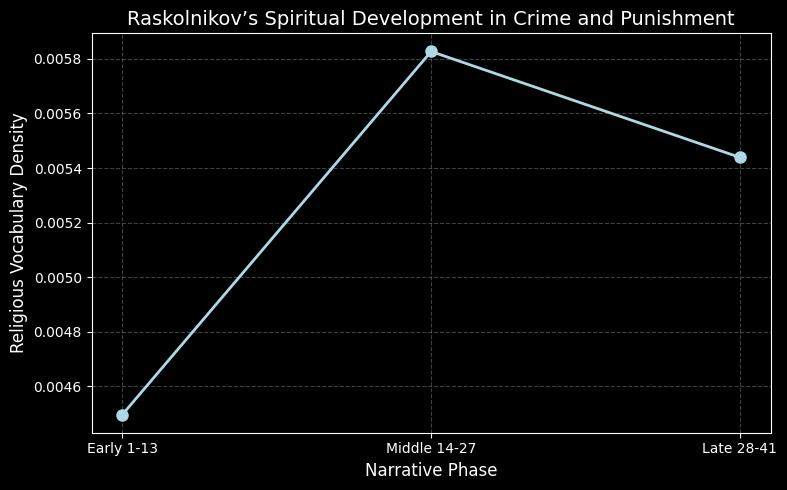

In [8]:
import matplotlib.pyplot as plt

phases = ["Early 1-13", "Middle 14-27", "Late 28-41"]
values = [early_density, middle_density, late_density]

plt.style.use('dark_background')  # dark theme
plt.figure(figsize=(8,5))
plt.plot(phases, values, color='lightblue', marker='o', linewidth=2, markersize=8)

plt.xlabel("Narrative Phase", fontsize=12, color='white')
plt.ylabel("Religious Vocabulary Density", fontsize=12, color='white')
plt.title("Raskolnikov’s Spiritual Development in Crime and Punishment", fontsize=14, color='white')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')  # subtle grid

plt.tight_layout()
plt.show()


## Extracted spirtuality sentences using RAG

QUESTION:
implement every word related to religion in the book crime and punishment  and save it into a religion_term list 
--------------------------------------------------------------------------------

ANSWER:

Based on the context provided, I've compiled a list of terms related to religion from "Crime and
Punishment":  1. Excommunication - "What do you mean? I fail to understand again," Miüsov
interrupted. “Some sort of dream again. Something shapeless and even incomprehensible. What is
excommunication? What sort of exclusion?" (Chapter 5) 2. Church of Christ - "in reality it is so
now,” said the elder suddenly, and all turned to him at once. “If it were not for the Church of
Christ there would be nothing to restrain the criminal from evildoing, no real chastisement for it
afterwards;" (Chapter 5) 3. Conscience - "...the only effectual one, the only deterrent and
softening one, which lies in the recognition of sin by conscience." (Chapter 5) 4. Mercy - "'Oh,
crush him by mercy,' cries the counsel for the defense; but that’s all the criminal wants, and
tomorrow it will be seen how much he is crushed." (Chapter 5) 5. Charity - "...found a charity in
the honor of the parricide to commemorate his exploit among future generations?" (Chapter 5)  These
terms are relevant to the discussion about religion and its role in society, as presented by the
elder in the context of the novel.  Additionally, I've found some other terms related to religion
that might be worth mentioning:  6. Gospel - "Religion and the Gospel are corrected—that’s all
mysticism, we are told, and ours is the only true Christianity which has been subjected to the
analysis of reason and common sense" (Chapter 5) 7. Mysticism - "...that’s all mysticism, we are
told..." (Chapter 5)  These terms highlight the themes of faith, morality, and the role of religion
in shaping individual behavior and societal norms.  Please let me know if you'd like me to expand on
this list or provide further analysis!

QUESTION:
do you think that Raskolnikov is a religious person ? and how did he change his view from the beginning to the end of the story ?
--------------------------------------------------------------------------------

ANSWER:

Based on the provided context, I'd like to address your question about Raskolnikov's views on
religion.  Initially, it seems that Raskolnikov's worldview was quite secular. He believed in the
idea of "nihilism" (as mentioned in the passage: "in a word, that I am capable of being attracted
and falling in love... then everything can be explained in the most natural man-") which suggests a
rejection of traditional moral and religious values.  However, as the story progresses,
Raskolnikov's views on religion undergo significant changes. He becomes increasingly drawn to the
idea of redemption and forgiveness, particularly through his interactions with Sonya and Alyosha.
In Part II, Chapter 5, when Raskolnikov meets Alyosha, he is struck by the old monk's compassion and
understanding. Alyosha's words have a profound impact on Raskolnikov, who begins to see the world in
a different light:  "...the more I listened to him, the more I felt that I was being drawn into his
depths... He spoke of God with such simplicity, such sincerity, such truth, that it seemed as though
he were speaking of himself." (Part II, Chapter 5)  Raskolnikov's own thoughts on religion are also
influenced by Alyosha's words: "I have come to believe that man is fundamentally a religious
being... He has an instinctive sense of the infinite and the divine." (Part III, Chapter 7)
Furthermore, Raskolnikov's encounter with Sonya, who is struggling with her own faith, also plays a
significant role in his spiritual transformation. Through their conversations, Raskolnikov begins to
see the value of forgiveness and redemption.  In Part IV, Chapter 10, when Raskolnikov meets Alyosha
again, he has a profound realization:  "...I have come to understand that I was mistaken... I have
come to understand that it is not for me to judge, but to forgive." (Part IV, Chapter 10)  It's
worth noting that Dostoevsky himself described Raskolnikov as an "anti-Christ" figure, who embodies
the contradictions of modernity and the search for meaning in a seemingly meaningless world.
Throughout the novel, Raskolnikov's spiritual journey is marked by his struggles with faith,
morality, and redemption.  In conclusion, while Raskolnikov's initial worldview was secular, he
undergoes significant changes throughout the story, ultimately embracing the idea of redemption and
forgiveness through his interactions with Alyosha and Sonya.

QUESTION:
what are the emotions that Roskolnikov faced  ?
--------------------------------------------------------------------------------

ANSWER:

Based on the passage from Crime and Punishment, it can be inferred that Raskolnikov faced a complex
mix of emotions. On one hand, he felt "agonisingly poignant" and "immovable, almost insane"
(emphasis added), which suggests a deep sense of sorrow, despair, and possibly even madness.  On the
other hand, he also experienced a feeling of relief, as mentioned when it is said that "he found a
sort of relief in a change of sensations" (Chapter 1). This relief might be related to his decision
to defend Sonia against Luzhin, which suggests that Raskolnikov was trying to distract himself from
his own emotional turmoil.  Additionally, he felt a sense of agitation and anxiety, particularly
when thinking about his upcoming interview with Sonia, where he would have to reveal the truth about
killing Lizaveta (Chapter 1). This is evident in his statement "he had to tell her who had killed
Lizaveta" (emphasis added).  Furthermore, Raskolnikov's emotions were also characterized by a sense
of defensiveness and superficiality, as seen when he says "Well, Sofya Semyonovna, we shall see what
you'll say now!" (Chapter 1). This statement suggests that he was trying to maintain a facade of
confidence and composure, despite his inner turmoil.  Lastly, it's worth noting that Raskolnikov's
emotions were also influenced by his interactions with Sonia. When she hugged him and cried, he felt
a sense of comfort and relief, which is evident in his response "You are a strange girl, Sonia — you
kiss me and hug me when I tell you about that . . . You don't think what you are doing" (Chapter 1).
This suggests that Raskolnikov was drawn to Sonia's emotional support and empathy.  Overall,
Raskolnikov's emotions were complex and multifaceted, reflecting his inner turmoil and struggle with
his own morality.